In [1]:
import joblib
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from data.data_utils import *
from atl_utils import *

In [2]:
### Load arrays
X_desc = joblib.load("./joblib_files/X_desc.joblib")
X_id = joblib.load("./joblib_files/X_id.joblib")
y = joblib.load("./joblib_files/y.joblib")
desc_names = joblib.load("./joblib_files/desc_names.joblib")

## In-domain CV performance by hyperparameter combinations

In [3]:
DEPTH_LIST = [1,2,3,5,None]
NUM_TREE_LIST = [1,3,5,10,20,50,100, 200]

def screen_params(
    desc_array, y_array,
    depth_list=DEPTH_LIST, num_tree_list=NUM_TREE_LIST, n_random_states=25
):
    """ For all combinations of hyperparameters, get in-domain ROC-AUC scores. """
    roc_auc_by_params = np.zeros((len(depth_list), len(num_tree_list), n_random_states))

    for x in range(n_random_states):
        for a, depth in enumerate(depth_list):
            for b, num_trees in enumerate(num_tree_list):
                rfc = RandomForestClassifier(random_state=42+x)
                param_grid = {
                    "max_depth":[depth],
                    "n_estimators":[num_trees]
                }

                grid_rfc = GridSearchCV(
                    rfc, 
                    param_grid=param_grid,
                    scoring="roc_auc", 
                    cv=5
                )
                grid_rfc.fit(desc_array, y_array)
                roc_auc_by_params[a, b, x] = grid_rfc.best_score_
        
    return roc_auc_by_params


def prep_heatmap(
    score_array, depth_list=DEPTH_LIST, num_tree_list=NUM_TREE_LIST, 
    std=True, vmin=0.5, vmax=1, cbar=False, mask=None
):
    ''' Plots heatmaps of performances at different levels.
    
    Parameters
    ----------
    score_array : np.2darray
        output of function above.
    depth_list, num_tree_list : list of ints
        inputs used throughout.
        
    Returns
    -------
    None
    '''
    xlen = len(num_tree_list) -1
    ylen = len(depth_list) - 1
    fig, ax = plt.subplots(figsize=(xlen,ylen))
    avg_score = np.mean(score_array,axis=2)
    annot_labels = [[0]*avg_score.shape[1] for x in range(avg_score.shape[0])]
    if std:
        std_score = np.std(score_array, axis=2)
        for i in range(avg_score.shape[0]):
            for j in range(avg_score.shape[1]):
                if round(std_score[i,j],2) >= 0.01 : 
                    avg_std = f"{round(avg_score[i,j],2)}\n({round(std_score[i,j],2)})"
                else : 
                    avg_std = f"{round(avg_score[i,j],2)}"
                annot_labels[i][j] = avg_std
    else :
        for i in range(avg_score.shape[0]):
            for j in range(avg_score.shape[1]):
                annot_labels[i][j] = round(avg_score[i,j],2)
    sns.heatmap(avg_score, cmap='viridis', cbar=cbar, square=True, mask=mask,
                vmin=vmin, vmax=vmax, annot=annot_labels, annot_kws={"fontfamily":"arial", "fontsize":10}, fmt='')
    ax.set_yticklabels([str(x) for x in depth_list], 
                       verticalalignment="center")
    ax.set_ylabel("Maximum Depth of Trees", fontsize=12, fontfamily="arial")
    ax.set_xticklabels(num_tree_list)
    ax.set_xlabel("Number of Trees", fontsize=12, fontfamily="arial")

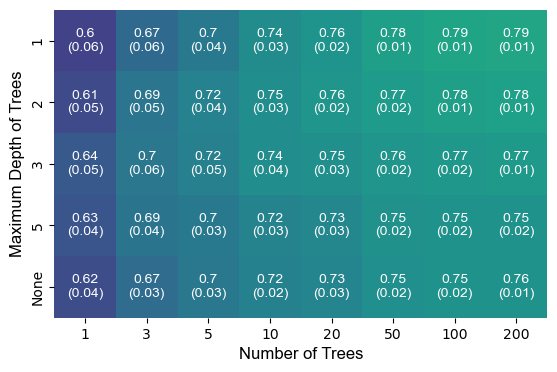

In [4]:
# Takes a couple minutes to run
roc_auc_by_params = screen_params(X_desc, y)
prep_heatmap(roc_auc_by_params)

## Preparation of all reaction condition candidates

In [5]:
additive_ids = np.array([
    [0, 0], # None
    [5, 1], # NaCl
    [5, 3], # NaI
    [6, 1], # MgCl2
    [6, 2], # MgBr2
    [7, 1], # KCl
    [7, 2], # KBr
    [7, 3], # KI
    [8, 1], # ZnCl2
    [9, 9], # succinimide
    [10, 1], # TMSCl
    [11, 1], # TBACl
    [11, 2], # TBABr
    [11, 3] # TBAI
])
additive_names = ["None", "NaCl", "NaI", "MgCl2", "MgBr2", "KCl", "KBr", "KI", "ZnCl2", "succinimide", "TMSCl", "TBACl", "TBABr", "TBAI"]
additive_name_to_id = {}
additive_id_to_name = {}
for i, row in enumerate(additive_ids) : 
    additive_id_to_name.update({
        tuple(row) : additive_names[i]
    })
for k, v in additive_id_to_name.items():
    additive_name_to_id.update({v:k})

print(additive_name_to_id)

{'None': (0, 0), 'NaCl': (5, 1), 'NaI': (5, 3), 'MgCl2': (6, 1), 'MgBr2': (6, 2), 'KCl': (7, 1), 'KBr': (7, 2), 'KI': (7, 3), 'ZnCl2': (8, 1), 'succinimide': (9, 9), 'TMSCl': (10, 1), 'TBACl': (11, 1), 'TBABr': (11, 2), 'TBAI': (11, 3)}


In [6]:
def prep_array_of_enumerated_candidates(list_of_component_arrays):
    """ Prepares an array of all enumerated reaction candidates.
    Not confirmed whether it will work for reactions of more than four components.
    
    Parameters
    ----------
    list_of_component_arrays : list of ndarray
        Arrays of candidates of each reaction component to be fully enumerated with others in the list.
        Can be id's or descriptor arrays.
        
    Returns
    -------
    enumerated_candidates : ndarray of shape (n_reactions, n_features)
        All reaction condition candidates. 
    """
    num_candidates = [x.shape[0] for x in list_of_component_arrays]
    enumerated_arrays = []
    for i, component_array in enumerate(list_of_component_arrays) :
        ndim = component_array.ndim
        if ndim == 1 :
            tile_shape = np.prod(num_candidates[:i])
        elif ndim == 2 :
            tile_shape = (np.prod(num_candidates[:i]), 1)
        if i == 0 :
            enumerated_arrays.append(
                np.repeat(component_array, np.prod(num_candidates[1:]), axis=0)
            )
        elif i < len(list_of_component_arrays) - 1:
            enumerated_arrays.append(
                np.tile(
                    np.repeat(component_array, np.prod(num_candidates[i+1:]), axis=0), 
                    tile_shape
                )
            )
        else : 
            enumerated_arrays.append(
                np.tile(component_array, tile_shape)
            )
        if ndim == 1 :
            enumerated_arrays[i] = enumerated_arrays[i].reshape(-1, 1)
    enumerated_candidates = np.hstack(tuple(enumerated_arrays))
    
    return enumerated_candidates

In [7]:
# Fixing MeCN as the second solvent
X_candidate_id = prep_array_of_enumerated_candidates([np.arange(1,6), np.arange(1,30), additive_ids, np.arange(1,10)])
print(X_candidate_id.shape)

(18270, 5)


In [8]:
Ni_source_onehot = np.identity(5)
ligand_desc = pd.read_excel("./data/descriptors.xlsx", sheet_name="Ligands", usecols=[3,4,5,6,7,9,10,12,14,15,17,18]).to_numpy()
additive_ion_onehot = np.zeros((14,11))
for i, row in enumerate(additive_ids) : 
    if i != 0 :
        for elem in row :
            additive_ion_onehot[i, elem-1] = 1
solvent_desc = pd.read_excel("./data/descriptors.xlsx", sheet_name="Solvents", usecols=[2,3,4,5,7,9]).to_numpy()
print(Ni_source_onehot.shape, ligand_desc.shape, additive_ion_onehot.shape, solvent_desc.shape)
print(X_desc.shape)

(5, 5) (29, 12) (14, 11) (9, 6)
(163, 58)


## Comparing suggestions from models of different hyperparameters

In [9]:
print(len(Ni_source_onehot), ligand_desc.shape, len(additive_ion_onehot), solvent_desc.shape)
X_candidate_desc = prep_array_of_enumerated_candidates([Ni_source_onehot, ligand_desc, additive_ion_onehot, solvent_desc])
Ala = pd.read_excel("./data/descriptors.xlsx", sheet_name="NHPI", usecols=list(np.arange(2,14))).to_numpy()[1,:]
MeBnKat = pd.read_excel("./data/descriptors.xlsx", sheet_name="Katritzky", usecols=list(np.arange(2,14))).to_numpy()[-1,:]

X_candidate_desc_Ala4MeBn = np.hstack((
    np.hstack((Ala, MeBnKat)).reshape(1,-1).repeat(X_candidate_desc.shape[0], axis=0),
    X_candidate_desc
))
print(X_candidate_desc_Ala4MeBn.shape, X_desc.shape)

5 (29, 12) 14 (9, 6)
(18270, 58) (163, 58)


In [10]:
### Comparing the selection frequency of reaction condition candidates between models of different number of trees
n_trees = [5, 10, 25, 50, 100, 200]
source_model_100_trees = []
source_model_25_trees = []
count_list = []
for i, n_tree in enumerate((n_trees)) : 
    rxn_counter = Counter()
    for j in range(100) :
        rfc = RandomForestClassifier(n_estimators=n_tree, max_depth=1, random_state=42+j)
        rfc.fit(X_desc, y)
        if n_tree == 25 :
            source_model_25_trees.append(rfc)
        elif n_tree == 100 : 
            source_model_100_trees.append(rfc)
        proba = rfc.predict_proba(X_candidate_desc_Ala4MeBn)[:,1]
        best_rxns = np.argsort(proba)[::-1][:24]
        rxn_counter.update(best_rxns)
    count_list.append(rxn_counter)

In [11]:
def counter_to_id_array(rxn_counts, n_rxns_to_consider, X_candidate_id=X_candidate_id):
    """ Prepares an id array from the Counter object. 
    
    Parameters
    ----------
    rxn_counts : : Counter
        Frequency of each reaction making it within the highest 'n_rxns' recommended by models.
    
    n_rxns_to_consider : int
        Number of reactions to consider

    X_candidate_id : np.2darray of shape (n_candidate_rxns, n_components)
        Id-Array of all candidate reactions.

    Returns
    -------
    rxn_id_array : np.2darray of shape (n_rxns_to_consider, n_components)
        Id array of reactions in the top 'n_rxns_to_consider'
    
    freq_array : np.1darray of shape (n_rxns_to_consider,)
        Recommendation frequencies of each reaction
    """
    # note that the -1 comes from the fact that the additive cation and anion will be combined into one
    rxn_id_array = np.zeros((
        n_rxns_to_consider, 
        X_candidate_id.shape[1]-1
    )) 
    freq_array = np.zeros((n_rxns_to_consider, ))
    
    for i, (rxn_id, freq) in enumerate(list(rxn_counts.most_common(n_rxns_to_consider))) :
        freq_array[i] = freq
        rxn_id_array[i, :2] = X_candidate_id[rxn_id, :2]
        rxn_id_array[i, 2] = int(
            str(X_candidate_id[rxn_id, 2]) + str(X_candidate_id[rxn_id, 3])
        )
        rxn_id_array[i, -1] = X_candidate_id[rxn_id, -1]
    return rxn_id_array, freq_array

import matplotlib.font_manager as font_manager

def plot_suggestion_counts(counter_list, n_trees):
    """ Plots the distribution of reactions making it into the top-24 recommendations by RFCs with different number of decision trees.
    
    Parameters
    ----------
    counter_list : list of Counter obj
        Counter objects that kept track of the frequencies of each reaction condition candidate being recommended.
    n_trees : list of ints
        Number of decision trees

    Returns
    -------
    None
    """
    fig, ax = plt.subplots()
    for i, rxn_counter in enumerate(counter_list) :
        count = sorted(list(rxn_counter.values()))
        bins = np.arange(len(count))
        ax.bar(bins, count, alpha=0.5, width=1, label=f"{n_trees[i]} Trees")
    font = font_manager.FontProperties(family='arial', size=12)
    ax.legend(loc="upper right", prop=font)
    ax.set_yticks(np.arange(11)*10)
    ax.set_yticklabels(np.arange(11)*10)
    ax.set_ylabel("Count", fontsize=14, fontfamily="arial")
    ax.set_xlabel("Reaction Index", fontsize=14, fontfamily="arial")
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(2)

#### On BocAla + 4MeBn

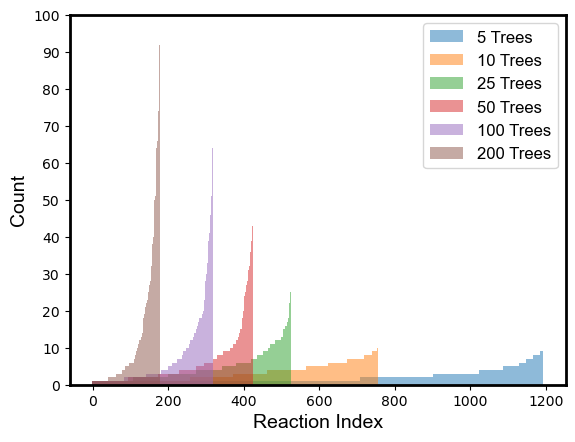

In [12]:
plot_suggestion_counts(count_list, n_trees)

In [32]:
joblib.dump(source_model_100_trees, "joblib_files/source_model_100_trees.joblib")

['joblib_files/source_model_100_trees.joblib']

In [13]:
joblib.dump(source_model_25_trees, "joblib_files/source_model_25_trees.joblib")

['joblib_files/source_model_25_trees.joblib']